<a href="https://colab.research.google.com/github/SeongBeomLEE/RecsysTutorial/blob/main/BERT4Rec/Multi_BERT4Rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Multi-BERT4Rec은 BERT4Rec을 임의로 수정한 모델로 Multi-VAE의 sequence한 버전이라고 할 수 있음



In [1]:
!pip install python-box

In [2]:
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from box import Box

import warnings

warnings.filterwarnings(action='ignore')
torch.set_printoptions(sci_mode=True)

# 1. 학습 설정

In [3]:
config = {
    'data_path' : "/content/drive/MyDrive/RecsysTutorial/Data/MovieLens" , # 데이터 경로

    'hidden_units' : 50, # Embedding size
    'num_heads' : 1, # Multi-head layer 의 수 (병렬 처리)
    'num_layers': 2, # block의 개수 (encoder layer의 개수)
    'dropout_rate' : 0.5, # dropout 비율

    'lr' : 0.001,
    'batch_size' : 32,
    'num_epochs' : 50,
    'num_workers' : 2,

    'valid_samples' : 10, # 검증에 사용할 sample 수
    'seed' : 22,
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Box(config)

# 2. 데이터 전처리

In [4]:
class MakeSequenceDataSet():
    """
    SequenceData 생성
    """
    def __init__(self, config):
        self.config = config
        self.df = pd.read_csv(os.path.join(self.config.data_path, 'ratings.csv'))
        
        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('movieId')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('userId')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['movieId'].apply(lambda x : self.item_encoder[x])
        self.df['user_idx'] = self.df['userId'].apply(lambda x : self.user_encoder[x])
        self.df = self.df.sort_values(['user_idx', 'timestamp']) # 시간에 따라 정렬
        self.user_train, self.user_valid, self.max_len = self.generate_sequence_data()

    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder 생성

        Args:
            col (str): 생성할 columns 명
        Returns:
            dict: 생성된 user encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder
    
    def generate_sequence_data(self) -> dict:
        """
        sequence_data 생성

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        max_len = 0
        user_train = {}
        user_valid = {}
        group_df = self.df.groupby('user_idx')
        for user, item in group_df:
            users[user].extend(item['item_idx'].tolist())
            if max_len < len(item):
                max_len = len(item)
        
        for user in users:
            np.random.seed(self.config.seed)

            user_total = users[user] 
            valid = np.random.choice(user_total, size = self.config.valid_samples, replace = False).tolist()
            train = []
            # index를 사용하면 속도를 더 빠르게 할 수 있음
            for item in user_total:
                if item not in valid:
                    train.append(item)

            user_train[user] = train
            user_valid[user] = valid # valid_samples 개수 만큼 검증에 활용 (현재 Task와 가장 유사하게)

        return user_train, user_valid, max_len
    
    def get_train_valid_data(self):
        return self.user_train, self.user_valid
    
    def make_matrix(self, user_list, train = True):
        """
        user_item_dict를 바탕으로 행렬 생성
        """
        mat = torch.zeros(size = (user_list.size(0), self.num_item))
        for idx, user in enumerate(user_list):
            if train:
                mat[idx, self.user_train[user.item()]] = 1
            else:
                mat[idx, self.user_train[user.item()] + self.user_valid[user.item()]] = 1
        return mat

In [5]:
class MulitBERTRecDataSet(Dataset):
    def __init__(self, user_train, num_user, max_len):
        self.user_train = user_train
        self.num_user = num_user
        self.max_len = max_len

    def __len__(self):
        # 총 user의 수 = 학습에 사용할 sequence의 수
        return self.num_user

    def __getitem__(self, user): 
        user_seq = (np.array(self.user_train[user]) + 1).tolist()
        mask_len = self.max_len - len(user_seq)
        user_seq = [0] * mask_len + user_seq

        return torch.LongTensor([user]), torch.LongTensor(user_seq)

# 3. 모델

In [6]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(ScaledDotProductAttention, self).__init__()
        self.hidden_units = hidden_units
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, Q, K, V, mask):
        """
        Q, K, V : (batch_size, num_heads, max_len, hidden_units)
        mask : (batch_size, 1, max_len, max_len)
        """
        attn_score = torch.matmul(Q, K.transpose(2, 3)) / math.sqrt(self.hidden_units) # (batch_size, num_heads, max_len, max_len)
        attn_score = attn_score.masked_fill(mask == 0, -1e9)  # 유사도가 0인 지점은 -infinity로 보내 softmax 결과가 0이 되도록 함
        attn_dist = self.dropout(F.softmax(attn_score, dim=-1))  # attention distribution
        output = torch.matmul(attn_dist, V)  # (batch_size, num_heads, max_len, hidden_units) / # dim of output : batchSize x num_head x seqLen x hidden_units
        return output, attn_dist


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout_rate):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads # head의 수
        self.hidden_units = hidden_units
        
        # query, key, value, output 생성을 위해 Linear 모델 생성
        self.W_Q = nn.Linear(hidden_units, hidden_units * num_heads, bias=False)
        self.W_K = nn.Linear(hidden_units, hidden_units * num_heads, bias=False)
        self.W_V = nn.Linear(hidden_units, hidden_units * num_heads, bias=False)
        self.W_O = nn.Linear(hidden_units * num_heads, hidden_units, bias=False)

        self.attention = ScaledDotProductAttention(hidden_units, dropout_rate)
        self.dropout = nn.Dropout(dropout_rate) # dropout rate
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6) # layer normalization

    def forward(self, enc, mask):
        """
        enc : (batch_size, max_len, hidden_units)
        mask : (batch_size, 1, max_len, max_len)
        
        """
        residual = enc # residual connection을 위해 residual 부분을 저장
        batch_size, seqlen = enc.size(0), enc.size(1)

        # Query, Key, Value를 (num_head)개의 Head로 나누어 각기 다른 Linear projection을 통과시킴
        Q = self.W_Q(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units) # (batch_size, max_len, num_heads, hidden_units)
        K = self.W_K(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units) # (batch_size, max_len, num_heads, hidden_units)
        V = self.W_V(enc).view(batch_size, seqlen, self.num_heads, self.hidden_units) # (batch_size, max_len, num_heads, hidden_units)

        # Head별로 각기 다른 attention이 가능하도록 Transpose 후 각각 attention에 통과시킴
        Q, K, V = Q.transpose(1, 2), K.transpose(1, 2), V.transpose(1, 2) # (batch_size, num_heads, max_len, hidden_units)
        output, attn_dist = self.attention(Q, K, V, mask) # output : (batch_size, num_heads, max_len, hidden_units) / attn_dist : (batch_size, num_heads, max_len, max_len)

        # 다시 Transpose한 후 모든 head들의 attention 결과를 합칩니다.
        output = output.transpose(1, 2).contiguous() # (batch_size, max_len, num_heads, hidden_units) / contiguous() : 가변적 메모리 할당
        output = output.view(batch_size, seqlen, -1) # (batch_size, max_len, hidden_units * num_heads)

        # Linear Projection, Dropout, Residual sum, and Layer Normalization
        output = self.layerNorm(self.dropout(self.W_O(output)) + residual) # (batch_size, max_len, hidden_units)
        return output, attn_dist


class PositionwiseFeedForward(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(PositionwiseFeedForward, self).__init__()

        self.W_1 = nn.Linear(hidden_units, hidden_units)
        self.W_2 = nn.Linear(hidden_units, hidden_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.layerNorm = nn.LayerNorm(hidden_units, 1e-6) # layer normalization

    def forward(self, x):
        residual = x
        output = self.W_2(F.relu(self.dropout(self.W_1(x))))
        output = self.layerNorm(self.dropout(output) + residual)
        return output


class BERT4RecBlock(nn.Module):
    def __init__(self, num_heads, hidden_units, dropout_rate):
        super(BERT4RecBlock, self).__init__()
        self.attention = MultiHeadAttention(num_heads, hidden_units, dropout_rate)
        self.pointwise_feedforward = PositionwiseFeedForward(hidden_units, dropout_rate)

    def forward(self, input_enc, mask):
        output_enc, attn_dist = self.attention(input_enc, mask)
        output_enc = self.pointwise_feedforward(output_enc)
        return output_enc, attn_dist


class MultiBERT4Rec(nn.Module):
    def __init__(self, num_user, num_item, hidden_units, num_heads, num_layers, max_len, dropout_rate, device):
        super(MultiBERT4Rec, self).__init__()

        self.num_user = num_user
        self.num_item = num_item
        self.hidden_units = hidden_units
        self.num_heads = num_heads
        self.num_layers = num_layers 
        self.device = device
        
        self.item_emb = nn.Embedding(num_item + 1, hidden_units, padding_idx = 0) # padding : 0 / item : 1 ~ num_item + 1
        self.dropout = nn.Dropout(dropout_rate)
        self.emb_layernorm = nn.LayerNorm(hidden_units, eps=1e-6)
        
        self.blocks = nn.ModuleList([BERT4RecBlock(num_heads, hidden_units, dropout_rate) for _ in range(num_layers)])
        self.out = nn.Linear(hidden_units, num_item)
    
    def forward(self, log_seqs):
        """
        log_seqs : (batch_size, max_len)

        ex)
        log_seqs = [
                [1, 2, 3, 4, 5],
                [0, 0, 0, 1, 2],
                [0, 0, 1, 2, 3]
        ]
        
        """
        seqs = self.item_emb(torch.LongTensor(log_seqs).to(self.device)) # (batch_size, max_len, hidden_units)
        seqs = self.emb_layernorm(self.dropout(seqs)) # LayerNorm

        mask_pad = torch.BoolTensor(log_seqs > 0).unsqueeze(1).repeat(1, log_seqs.shape[1], 1).unsqueeze(1).to(self.device) # mask for zero pad / (batch_size, 1, max_len, max_len)
        for block in self.blocks:
            seqs, attn_dist = block(seqs, mask_pad)
        out = self.out(seqs) # (batch_size, max_len, num_item) / mean 계산을 다른 방식으로 진행하면 더 좋은 성능을 낼 수 있을 것
        return out.mean(dim = 1)

In [7]:
class MultiLoss(nn.Module):
    def __init__(self):
        super(MultiLoss, self).__init__()
        
    def forward(self, x_pred, user_ratings):
        mll = (F.log_softmax(x_pred, dim=-1) * user_ratings).sum(dim=-1).mean()
        return -mll

# 4. 학습 함수

In [8]:
def get_ndcg(pred_list, true_list):
    idcg = sum((1 / np.log2(rank + 2) for rank in range(1, len(pred_list))))
    dcg = 0
    for rank, pred in enumerate(pred_list):
        if pred in true_list:
            dcg += 1 / np.log2(rank + 2)
    ndcg = dcg / idcg
    return ndcg

# hit == recall == precision
def get_hit(pred_list, true_list):
    hit_list = set(true_list) & set(pred_list)
    hit = len(hit_list) / len(true_list)
    return hit

def train(model, criterion, optimizer, data_loader, make_data_set):
    model.train()
    loss_val = 0
    for users, seq in data_loader:
        mat = make_data_set.make_matrix(users)
        mat = mat.to(device)
        
        logits = model(seq)

        optimizer.zero_grad()
        
        loss = criterion(logits, mat)

        loss_val += loss.item()

        loss.backward()
        optimizer.step()
    
    loss_val /= len(data_loader)

    return loss_val

def evaluate(model, user_train, user_valid, data_loader, make_data_set):

    model.eval()

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10

    with torch.no_grad():
        for users, seq in data_loader:
            mat = make_data_set.make_matrix(users)
            mat = mat.to(device)

            recon_mat = model(seq)
            recon_mat[mat == 1] = -np.inf
            rec_list = recon_mat.argsort(dim = 1)

            for user, rec in zip(users, rec_list):
                uv = user_valid[user.item()]
                up = rec[-10:].cpu().numpy().tolist()[::-1]
                NDCG += get_ndcg(pred_list = up, true_list = uv)
                HIT += get_hit(pred_list = up, true_list = uv)

    NDCG /= len(data_loader.dataset)
    HIT /= len(data_loader.dataset)

    return NDCG, HIT

# 5. 학습

In [9]:
make_sequence_dataset = MakeSequenceDataSet(config = config)
user_train, user_valid = make_sequence_dataset.get_train_valid_data()

In [10]:
multi_bert4rec_dataset = MulitBERTRecDataSet(
    user_train = user_train, 
    num_user = make_sequence_dataset.num_user,
    max_len = make_sequence_dataset.max_len, 
    )

In [11]:
data_loader = DataLoader(
    multi_bert4rec_dataset, 
    batch_size = config.batch_size,
    shuffle = True, 
    pin_memory = True,
    num_workers = config.num_workers,
    )

In [12]:
model = MultiBERT4Rec(
    num_user = make_sequence_dataset.num_user, 
    num_item = make_sequence_dataset.num_item, 
    hidden_units = config.hidden_units, 
    num_heads = config.num_heads, 
    num_layers = config.num_layers, 
    max_len = make_sequence_dataset.max_len, 
    dropout_rate = config.dropout_rate, 
    device = device,
    ).to(device)

criterion = MultiLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [13]:
loss_list = []
ndcg_list = []
hit_list = []
for epoch in range(1, config.num_epochs + 1):
    tbar = tqdm(range(1))
    for _ in tbar:
        train_loss = train(
            model = model, 
            criterion = criterion, 
            optimizer = optimizer, 
            data_loader = data_loader,
            make_data_set = make_sequence_dataset)

        ndcg, hit = evaluate(
            model = model, 
            user_train = user_train, 
            user_valid = user_valid,
            data_loader = data_loader,
            make_data_set = make_sequence_dataset,
            )

        loss_list.append(train_loss)
        ndcg_list.append(ndcg)
        hit_list.append(hit)

        tbar.set_description(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

Epoch:   1| Train loss: 1245.30018| NDCG@10: 0.03046| HIT@10: 0.02355: 100%|██████████| 1/1 [00:35<00:00, 35.63s/it]
Epoch:   2| Train loss: 1166.30241| NDCG@10: 0.06658| HIT@10: 0.05142: 100%|██████████| 1/1 [00:33<00:00, 33.47s/it]
Epoch:   3| Train loss: 1128.74405| NDCG@10: 0.10057| HIT@10: 0.06721: 100%|██████████| 1/1 [00:33<00:00, 33.63s/it]
Epoch:   4| Train loss: 1120.66440| NDCG@10: 0.10325| HIT@10: 0.07124: 100%|██████████| 1/1 [00:33<00:00, 33.48s/it]
Epoch:   5| Train loss: 1119.73603| NDCG@10: 0.10463| HIT@10: 0.07392: 100%|██████████| 1/1 [00:33<00:00, 33.38s/it]
Epoch:   6| Train loss: 1116.89737| NDCG@10: 0.10762| HIT@10: 0.07645: 100%|██████████| 1/1 [00:33<00:00, 33.52s/it]
Epoch:   7| Train loss: 1115.11793| NDCG@10: 0.11134| HIT@10: 0.07928: 100%|██████████| 1/1 [00:33<00:00, 33.48s/it]
Epoch:   8| Train loss: 1112.73313| NDCG@10: 0.11251| HIT@10: 0.08152: 100%|██████████| 1/1 [00:33<00:00, 33.50s/it]
Epoch:   9| Train loss: 1106.19303| NDCG@10: 0.11587| HIT@10: 0.

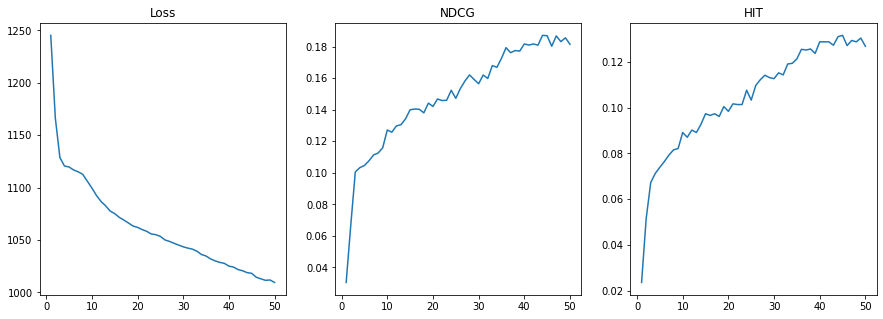

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax = ax.flatten()
epochs = [i for i in range(1, config.num_epochs + 1)]

ax[0].plot(epochs, loss_list)
ax[0].set_title('Loss')

ax[1].plot(epochs, ndcg_list)
ax[1].set_title('NDCG')

ax[2].plot(epochs, hit_list)
ax[2].set_title('HIT')
plt.show()